In [1]:
import numpy as np
import seaborn, math, os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit, least_squares
from copy import deepcopy
import scipy.stats as stats

C:\Anaconda\envs\py34\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%matplotlib notebook
plt.style.use('seaborn-notebook')

In [3]:
np.set_printoptions(precision=3, suppress=True)

In [4]:
%run medidas_biodiversidad.py

In [5]:
# leer datos:
def leer_datos(het):
    files = os.listdir("./datos/exp1")
    files.sort()
    files = list(filter(lambda x: x[6] == het, files))
    
    datos = [np.load("./datos/exp1/" + file) for file in files]
    comunidad = [file[9:12] for file in files]
    
    return datos, comunidad

In [6]:
def calcular_riqueza(datos, paisajes, bio_min = 5.):
    riquezas = np.zeros((40, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            riquezas[comunidad, intensificacion] = riqueza_agricola(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)[1]
    return riquezas

In [20]:
def calcular_sw(datos, paisajes, bio_min = 5.):
    riquezas = np.zeros((40, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            riquezas[comunidad, intensificacion] = shannon_wiener(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)
    return riquezas

In [7]:
def calcular_prueba(datos, paisajes, bio_min = 5.):
    riquezas = np.zeros((40, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            riquezas[comunidad, intensificacion] = medida_prueba(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)
    return riquezas

In [8]:
def calcular_biomasa(datos, paisajes, bio_min = 5.):
    biomasas = np.zeros((40, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            biomasas[comunidad, intensificacion] = riqueza_agricola(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)[0]
            
    return biomasas

In [9]:
def calcular_promedio(riquezas):
    """Recibe datos de riqueza.
    """
    promedios = np.zeros(10)
    std = np.zeros(10)
    for i in range(10):
        promedios[i] = np.mean(riquezas[riquezas[:, 0]>=0, i]) #Por qué >=???
        std[i] = np.std(riquezas[:, i])
    return promedios, std

In [10]:
paisajes = [None] * 5
for het in range(5):
    paisajes[het] = np.load("paisajes_h{}.npy".format(het))

In [21]:
datos = [None] * 5
riquezas = [None] * 5
sw = [None] * 5
biomasas = [None] * 5
riquezas_mean = [None] * 5
riquezas_sd = [None] * 5
biomasas_mean = [None] * 5
biomasas_sd = [None] * 5
sw_mean = [None] * 5
sw_sd = [None] * 5

prueba = [None] * 5
prueba_mean = [None] * 5
prueba_sd = [None] * 5

for het in range(5):
    datos[het] = leer_datos(str(het))[0]
    
    riquezas[het] = calcular_riqueza(datos[het], paisajes[het], bio_min = 5)
    riquezas_mean[het], riquezas_sd[het] = calcular_promedio(riquezas[het])
    sw[het] = calcular_sw(datos[het], paisajes[het], bio_min = 5)
    sw_mean[het], sw_sd[het]  = calcular_promedio(sw[het])
    biomasas[het] = calcular_biomasa(datos[het], paisajes[het], bio_min = 5)
    
    #normalizar biomasas:
    for i in range(len(biomasas[het])):
        biomasas[het][i] = biomasas[het][i] / biomasas[het][i, 0]  
    
    biomasas_mean[het], biomasas_sd[het] = calcular_promedio(biomasas[het])
    
    prueba[het] = calcular_prueba(datos[het], paisajes[het], bio_min = 5)
    prueba_mean[het], prueba_sd[het] = calcular_promedio(prueba[het])
    

C:\Anaconda\envs\py34\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<IPython.core.display.Javascript object>


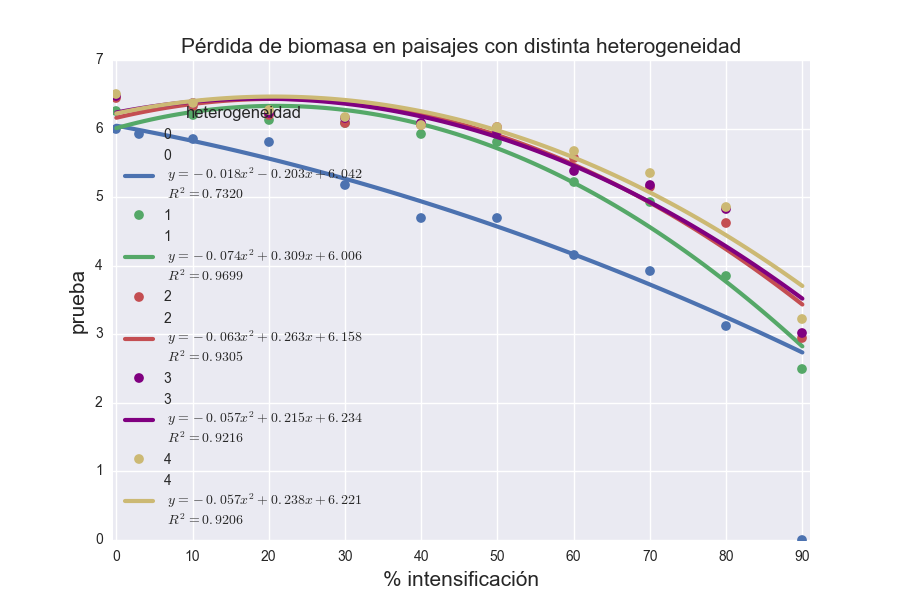

In [74]:
#Riqueza: Graficar promedios con curva ajustada ponderada
%matplotlib notebook
plt.style.use('seaborn-notebook')
seaborn.set_palette("deep", color_codes=True)

#seaborn.color_palette("deep", 8):
promedios = prueba_mean
sd = prueba_sd

y = [None] * 5
res = [None] * 5
p = [None] * 5
r2 = [None] * 5

x = np.linspace(0, 9, 100)
xdata = np.array(range(10))
xlabels = np.array(range(10)) * 10 

puntos = ["o", "p", "d", "v", "s"]

colors = ["b", 'g', 'r', 'purple', 'y']

for het in range(5):
    res[het] = np.polyfit(xdata, promedios[het], 2, w=sd[het])
    p[het] = np.poly1d(res[het])
    r2[het] = 1 - ((np.sum((p[het](range(10)) - promedios[het])**2)) / (np.sum((promedios[het] - np.mean(promedios[het]))**2)))

fig = plt.figure(figsize=(9, 6), dpi = 100)
ax = plt.subplot(111)

for het in range(0, 5):
    y[het] = p[het](x)
    plt.plot(xdata, promedios[het], 'o', label='{}'.format(het), color= colors[het]) #data points
    plt.plot(x, y[het], lw = 3, color= colors[het], label='{} \n $y = {:+.3f} x^2 {:+.3f} x {:+.3f}$ \n $R^2={:.4f}$ '.format(
                            het, float(p[het][2]), float(p[het][1]), float(p[het][0]), float(r2[het]))) #fit
    #plt.errorbar(xdata, promedios[het], yerr=sd[het], fmt=puntos[het], color = colors[het])

#plt.ylim(-0.05, 1.05)
plt.xlim(-0.05, 9.1)
plt.xticks(xdata, xlabels)
plt.xlabel("% intensificación", size = 15)
plt.ylabel("prueba", size = 15)
#plt.yscale("log")
plt.title("Pérdida de biomasa en paisajes con distinta heterogeneidad", size = 15)
plt.legend(loc='best', fontsize = "small", title="heterogeneidad")

#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

#plt.legend(loc='center left', fontsize = "small", title="heterogeneidad", bbox_to_anchor=(1, 0.5))

plt.show()

In [49]:
# contar cuántas comunidades no tuvieron cambios en niveles de intensificación
riquezas = np.array(riquezas)
count = 0
for het in range(5):
    for c in range(40):
        if riquezas[het, c, 0] != riquezas[het, c, 8]:
            count += 1

### Intentando Anova

In [25]:
# shape: [het, comunidades, intensificación]
riquezas = np.array(riquezas)
sw = np.array(sw)
prueba=np.array(prueba)
biomasas = np.array(biomasas)

In [ ]:
riquezas[:, :, 0]

In [ ]:
df = pandas.DataFrame(riquezas[:, :, 0], columns=list(np.array(range(40))))

In [ ]:
df = df.T

In [62]:
i = 8
stats.f_oneway(riquezas[0, :, i],
               riquezas[1, :, i],
               riquezas[2, :, i],
               riquezas[3, :, i],
               riquezas[4, :, i])

F_onewayResult(statistic=2.2969663627790005, pvalue=0.060509163577726191)

In [75]:
i = 4
stats.f_oneway(prueba[0, :, i],
               prueba[1, :, i],
               prueba[2, :, i],
               prueba[3, :, i],
               prueba[4, :, i])

F_onewayResult(statistic=4.1416510670160998, pvalue=0.0030445789093610912)

In [46]:
i = 1
c= 0
anova = stats.f_oneway(riquezas_norm[0, :, i],
                       riquezas_norm[1, :, i],
                       riquezas_norm[2, :, i],
                       riquezas_norm[3, :, i],
                       riquezas_norm[4, :, i])
print(anova)

NameError: name 'riquezas_norm' is not defined

In [159]:
# Esto no
nivel = 
ttest = np.zeros([5, 5, 2])
for i in range(5):
    for j in range(5):
        print(i, j)
        ttest[i, j] = stats.ttest_ind(riquezas[i, :, nivel],riquezas[j, :, nivel], equal_var=False)       

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [175]:
# ¿En qué niveles de intensificación hay una diferencia significativa entre h1 y h0?
for n in range(10):
    ttest = stats.ttest_ind(riquezas[0, :, n],
                            riquezas[2, :, n], equal_var=False)
    print("nivel {}:  ".format(n), ttest[0], ttest[1])
    

nivel 0:   0.067189369622 0.946602936153
nivel 1:   0.0 1.0
nivel 2:   0.131089289611 0.896042204492
nivel 3:   0.0667427701922 0.946957344643
nivel 4:   -0.066170829268 0.947411137536
nivel 5:   0.190865616196 0.849127823401
nivel 6:   0.740348794882 0.461311215168
nivel 7:   0.4472135955 0.655960277996
nivel 8:   0.0599953851479 0.9523128743
nivel 9:   0.482575660928 0.630748727657


In [76]:
# ¿En qué niveles de intensificación hay una diferencia significativa entre h1 y h0?
for n in range(10):
    ttest = stats.ttest_ind(prueba[4, :, n],
                            prueba[3, :, n], equal_var=False)
    print("nivel {}:  ".format(n), ttest[0], ttest[1])

nivel 0:   0.067189369622 0.946602936153
nivel 1:   0.0 1.0
nivel 2:   0.131089289611 0.896042204492
nivel 3:   0.0667427701922 0.946957344643
nivel 4:   -0.066170829268 0.947411137536
nivel 5:   0.190865616196 0.849127823401
nivel 6:   0.740348794882 0.461311215168
nivel 7:   0.4472135955 0.655960277996
nivel 8:   0.0599953851479 0.9523128743
nivel 9:   0.482575660928 0.630748727657


<IPython.core.display.Javascript object>


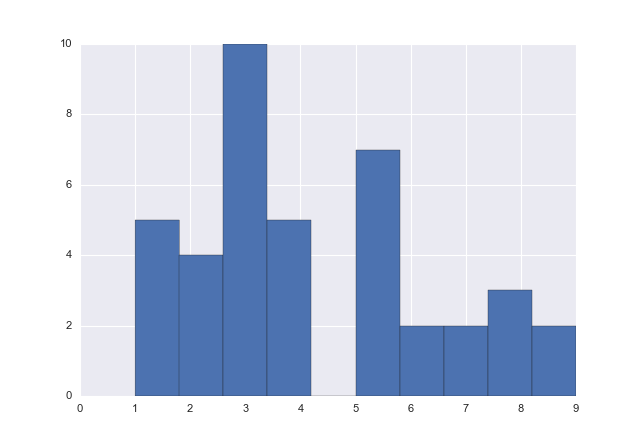

In [86]:
fig = plt.figure()
plt.hist(prueba[0, :, 6])
#plt.hist(prueba[3, :, 0])
#plt.ylim(0, 10)
#plt.xlim(0, 9)
plt.show()

In [229]:
het = 4
ttest2 = stats.f_oneway(riquezas[het, :, 0],
                         riquezas[het, :, 1],
                         riquezas[het, :, 2],
                         riquezas[het, :, 3],
                         riquezas[het, :, 4],
                         riquezas[het, :, 5],
                         riquezas[het, :, 6],
                         riquezas[het, :, 7],
                         riquezas[het, :, 8],
                         riquezas[het, :, 9])
ttest2

F_onewayResult(statistic=12.835130108925149, pvalue=6.0095930676454654e-18)

Anterior:

In [63]:
#normalizar riquezas
riquezas_norm = deepcopy(riquezas)
for h in range(5):
    for i in range(len(riquezas[h, :, :])):
        if riquezas[h, i, 0] >= 0:
            riquezas_norm[h, i, :] = riquezas_norm[h, i, :] / riquezas[h, i, 0]
        else:
            riquezas_norm[h, i, :] = 0

In [65]:
def sigmoid(x, A, K, B, v, Q, C):
    y = A + (K - A)/((C + Q*np.exp(-B*x))**(1./v))
    return y

def exp_decay(x, y0, λ):
    ln_y = np.log(y0) - λ*x
    return ln_y

In [ ]:
xdata = np.array(range(10))
ydata0 = promedios0[0]
ydata4 = promedios4[0]


#popt, pcov = curve_fit(sigmoid, xdata, ydata, p0=(9, 7, 2, 2, 5000, 0.02), bounds = (0, np.inf))
#popt, pcov = curve_fit(line, xdata, ydata)
#slope, intercept, r_value, p_value, std_err = stats.linregress(xdata,ydata)
res = np.polyfit(xdata, ydata, 2)
p = np.poly1d(res)
#print(slope, intercept)
#print(r_value**2)
#print(pcov)
print(res)

In [ ]:
%matplotlib inline
x = np.linspace(0, 9, 100)
y = p(x)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(x,y, label='fit')
plt.ylim(0, 10)
plt.legend(loc='best')
plt.show()

In [106]:
riquezas = deepcopy(riquezas[4,:,:])
xdata = np.array(range(10))
all_y = []
for i in range(len(riquezas)):
    if riquezas[i, 0] >= 4:
        #print(i)
        ydata = riquezas[i, :]
        try:
            popt, pcov = curve_fit(sigmoid, xdata, ydata, 
                               p0=(9, 7, 2, 2, 5000, 0.02), bounds = (0, np.inf))
        except RuntimeError:
            pass
        all_y.append(popt)
all_y = np.array(all_y)

IndexError: too many indices for array

<IPython.core.display.Javascript object>


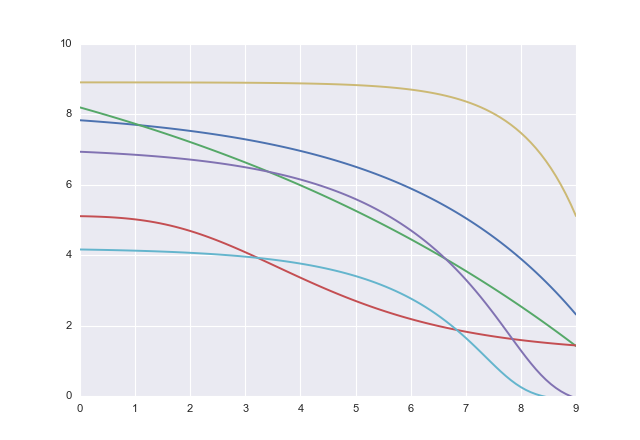

In [103]:
#%matplotlib inline
fig = plt.figure()
x = np.linspace(0, 9, 100)
for popt in all_y[[2,3, 4, 5, 6, 36]]:
    y = sigmoid(x, *popt)
    #plt.plot(xdata, ydata, 'o', label='data')
    plt.plot(x,y)
plt.ylim(0, 10)
#plt.legend(loc='best')
plt.show()

In [ ]:
import pandas as pandas

In [ ]:
%matplotlib inline
df = pandas.DataFrame(riquezas[riquezas[:, 0]>=0], columns=list(np.array(range(10)) * 10))

fig = plt.figure(figsize=(15, 8))
seaborn.violinplot(df[df.loc[:, 0]>0], bw = 0.2)
#seaborn.violinplot(df)

plt.show() 

<IPython.core.display.Javascript object>


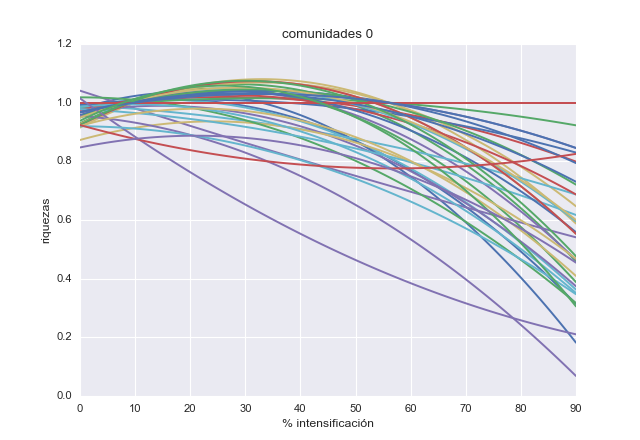

In [66]:
# Fit a 2 polynomial to every community
riquezasb = deepcopy(riquezas_norm[4,:,:])
%matplotlib notebook
seaborn.color_palette("husl", 6)
xdata = np.array(range(10))
labels = np.array(range(10)) * 10
res = [None] * 40
p = [None] * 40

for c in range(40):
    res[c] = np.polyfit(xdata, riquezasb[c, :], 2)
    p[c] = np.poly1d(res[c])

fig = plt.figure()
x = np.linspace(0, 9, 100)
y = [None] * 40

for c in range(40):
    y[c] = p[c](x)
    #plt.plot(xdata, riquezasb[c, :], 'o', label='{}'.format(c))
    #plt.plot(xdata, promedios[1], 'o', label='{}'.format(het))
    plt.plot(x, y[c], label='{}'.format(c))

#plt.ylim(0, 10)
plt.xticks(xdata, labels)
plt.xlabel("% intensificación")
plt.ylabel("riquezas")
plt.title("comunidades 0")
#plt.legend(loc='best', title="c")
plt.show()

In [33]:
def residuals(p, real):
    x = np.array(range(10))
    residual = p(x) - real
    return np.sum(residual**2)

In [34]:
residuals1 = np.zeros(40)
residuals2 = np.zeros(40)
for c in range(40):
    residuals1[c] = residuals(p1[c], riquezas[1, c, :])
    residuals2[c] = residuals(p2[c], riquezas[1, c, :])

In [40]:
for c in range(40): print(residuals1[c], residuals2[c])

8.29090909091 2.76818181818
14.0242424242 3.08484848485
1.28189897098e-29 1.45939267466e-29
5.85454545455 0.733333333333
2.20606060606 0.721212121212
7.58787878788 3.22424242424
5.16363636364 1.82272727273
14.0242424242 1.90303030303
1.2 0.442424242424
0.872727272727 0.865151515152
14.2060606061 6.44848484848
3.95151515152 2.24696969697
5.40606060606 1.04242424242
2.61818181818 1.52727272727
3.05454545455 1.5696969697
5.85454545455 0.733333333333
6.75151515152 2.01666666667
6.09696969697 0.975757575758
5.89090909091 3.43636363636
2.09696969697 2.06666666667
4.10207670715e-29 2.76101316827e-29
0.824242424242 0.339393939394
7.41818181818 2.68333333333
3.62424242424 1.68484848485
11.2242424242 4.40606060606
9.29696969697 2.47878787879
10.4727272727 3.19242424242
1.73333333333 0.45303030303
5.58787878788 1.5803030303
11.9878787879 3.73787878788
2.82424242424 0.369696969697
3.05454545455 1.5696969697
5.12759588394e-29 5.83757069864e-29
1.80606060606 1.04848484848
10.496969697 1.73939393939


In [31]:
test = (p1[0](np.array(range(10))) - riquezas[1, 0, :])
print(test)
print(test**2)
print(np.sum(test**2))

[ 1.03636364  0.47272727 -0.09090909 -0.65454545 -0.21818182 -0.78181818
 -1.34545455 -0.90909091  1.52727273  0.96363636]
[ 1.07404959  0.22347107  0.00826446  0.42842975  0.04760331  0.61123967
  1.81024793  0.82644628  2.33256198  0.92859504]
8.29090909091


In [ ]:
# Execute this cell to load the notebook's style sheet, then ignore it
# Original de numericalmooc, por Lorena Barba
from IPython.core.display import HTML
css_file = "C:/Users/hp\Desktop/proyectof/style2.css"
HTML(open(css_file, "r").read())